In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)



e:\User\PC\ads_enefit_ueh\ads_enfit


In [2]:
from libs.common import *
from config.config import *
from models.models import VGG16, LSTM_model

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


e:/User/PC/ads_enefit_ueh/ads_enfit


In [3]:
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp2"
os.makedirs(save_dir, exist_ok=True)

In [4]:
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [5]:
# wandb.init(project="enefit_prediction_consumer")


In [6]:
X_train=pd.read_csv(f'{save_dir}/X_train.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid.csv', index_col=None)
X_test=pd.read_csv(f'{save_dir}/X_test.csv', index_col=None)
y_test=pd.read_csv(f'{save_dir}/y_test.csv', index_col=None)


In [7]:
X_train.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
X_test.drop(columns=['Unnamed: 0'], inplace=True)
y_test.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(1079454, 141) (1079454, 1) (531672, 141) (531672, 1) (6144, 141) (6144, 1)


In [8]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
lstm_model = LSTM_model(input_shape=(X_train.shape[1],1)).model
lr=0.0001
lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae', r2])
lstm_model.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 141, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 96)                12384     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                6208      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0    

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=2,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='LSTM.hdf5', 
    monitor='val_loss', 
    mode='min',
    save_best_only=True, 
    verbose=1,  
    save_format="tf"
)

In [11]:
lstm_model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[early_stopping,lr_scheduler,checkpoint_callback])

Epoch 1/10000
16866/16867 [============================>.] - ETA: 0s - loss: 230834.7188 - mae: 132.1347 - r2: 0.6239
Epoch 1: val_loss improved from inf to 172316.89062, saving model to LSTM.hdf5
16867/16867 [==============================] - 1542s 91ms/step - loss: 230829.7500 - mae: 132.1338 - r2: 0.6240 - val_loss: 172316.8906 - val_mae: 119.0982 - val_r2: 0.8470 - lr: 1.0000e-04
Epoch 2/10000
16866/16867 [============================>.] - ETA: 0s - loss: 154588.2500 - mae: 112.6423 - r2: 0.7102
Epoch 2: val_loss improved from 172316.89062 to 130791.77344, saving model to LSTM.hdf5
16867/16867 [==============================] - 1654s 98ms/step - loss: 154608.0938 - mae: 112.6488 - r2: 0.7102 - val_loss: 130791.7734 - val_mae: 100.7018 - val_r2: 0.8876 - lr: 1.0000e-04
Epoch 3/10000
16867/16867 [==============================] - ETA: 0s - loss: 143549.4375 - mae: 108.1738 - r2: 0.7347
Epoch 3: val_loss improved from 130791.77344 to 116980.75781, saving model to LSTM.hdf5
16867/16867

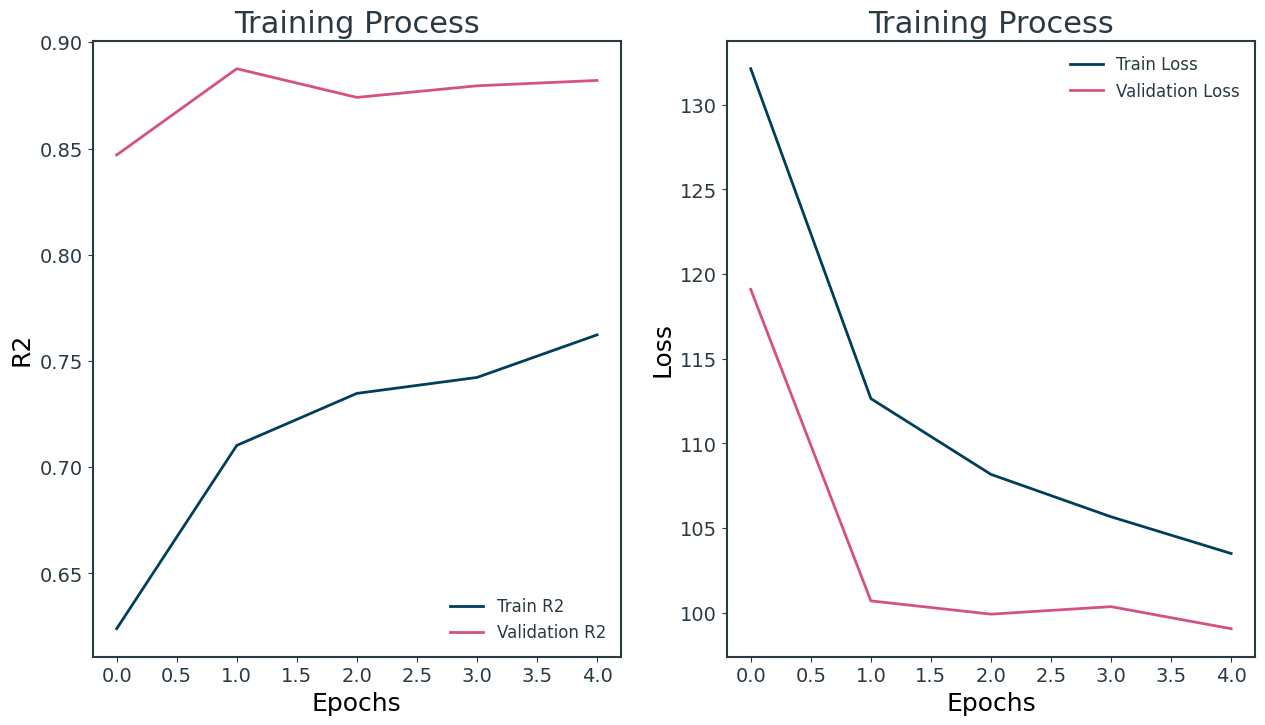

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

history = lstm_model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train R2')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation R2')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('R2')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = lstm_model.predict(X_test)

# Tính toán R2 Score
r2 = r2_score(y_test, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


192/192 [==============================] - 3s 15ms/step
R2 Score: 0.8031223434270198
MAE: 142.2037374870802
